<a href="https://colab.research.google.com/github/Nexx136/sandbox/blob/master/rl_week1_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install --upgrade ipykernel

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 0. Инициализация среды и ее свойства

Посмотрим как выглядит среда, какую в среднем награду получает агент и сколько длится эпизод. После оптимизации награда должна стать больше, а длительность меньше

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

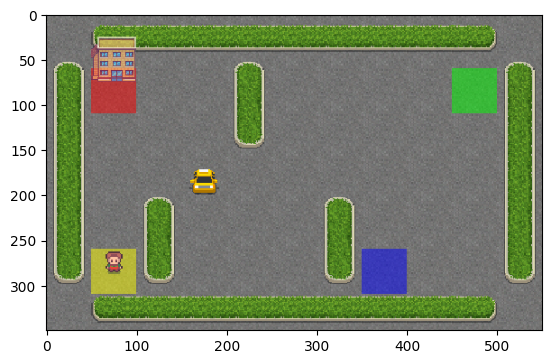

In [3]:
env = gym.make('Taxi-v3')
render = lambda : plt.imshow(env.render(mode='rgb_array'))
env.reset()
render()

In [4]:
env.action_space

Discrete(6)


    

```
такси может делать такие действия:
    0: move south
    1: move north
    2: move east
    3: move west
    4: pickup passenger
    5: drop off passenger
```




In [5]:
print(f' такси может принимать {env.observation_space} состояний ')

 такси может принимать Discrete(500) состояний 


# 1. Задание 1. Оптимизация алгоритма методом кросс-энтропии

## 1.1   статистики в случае случайного выбора действий

запустим 500 эпизодов чтобы посмотреть на среднююю длительность и награду. Далее мы эти данные для обучения использовать не будем.

In [6]:
%%time
rewards = []
steps = []
for _ in range(500):
    done = False
    num_steps = 0
    total_reward = 0
    env.reset()
    while not done:
        action = np.random.choice(6, size=1)[0]
        next_state, reward, done, info = env.step(action)
        num_steps += 1
        total_reward += reward
    rewards.append(total_reward)
    steps.append(num_steps)

CPU times: user 6.98 s, sys: 287 ms, total: 7.27 s
Wall time: 8.29 s


In [7]:
print(f'''0.90 - 0.99 quantiles for reward:
0.90 :{np.quantile(rewards, 0.9)},
0.95 :{np.quantile(rewards, 0.95)},
0.975:{np.quantile(rewards, 0.975)},
0.99 :{np.quantile(rewards, 0.99)},
on average we get reward: {np.mean(rewards)} with {np.mean(num_steps)} steps.
''')

0.90 - 0.99 quantiles for reward:
0.90 :-677.0,
0.95 :-646.7000000000003,
0.975:-524.6500000000003,
0.99 :-250.99,
on average we get reward: -766.652 with 200.0 steps.



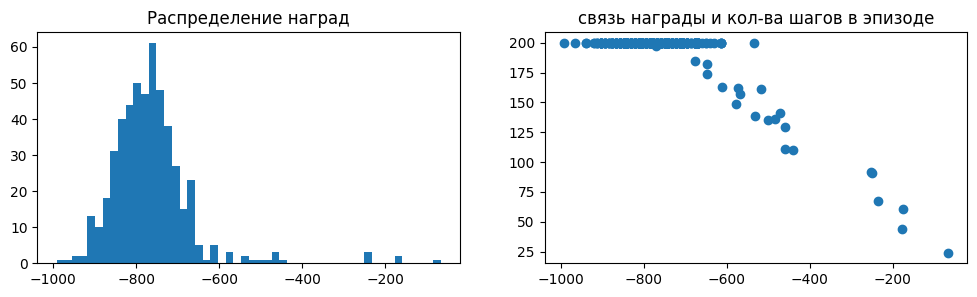

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax[0].hist(rewards, bins=50)
ax[0].set_title('Распределение наград')
ax[1].scatter(rewards, steps)
ax[1].set_title('связь награды и кол-ва шагов в эпизоде');

## 1.2 метод кросс-энтропии для разных значений гиперпараметров

Найдем наилучшие значения гиперпараметров, при которых в среднем будем получать не отрицательный reward. Перебирать будем значения:


*   q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
*   trajectory_n (кол-во эпизодов в итерации) = [20, 50] + попробуем вариант с апдейтом политики после каждого элитного эпизода

Лучшим будем считать тот вариант, который будет приносить не отрицательную награду за наименьшее число шагов. остановимся, когда среднее по последним trajectory_n будет >=0






определим вспомогательные функции:

In [9]:
def update_strategy(cool_model:np.array, curr_strategy:list):
    '''
        функция  принимает на вход матрицу для принятия решения о действии cool_model и апдейтит ее значения по переданному эпизоду s
    '''
    for c in curr_strategy:
        cool_model[c[0], c[1]] += 1
    return cool_model

In [10]:
q = [0.7, 0.8, 0.85, 0.9, 0.95, 0.99]
trajectory = [1, 20, 50]
logs = []
n_states, n_actions = 500, 6
iteration_n0 = 100
iteration_n = iteration_n0 * trajectory[2]


for q_i in q:
    for t in trajectory:
        mean_reward = - 1000
        thres = -1000
        cool_model = np.ones((n_states, n_actions))

        n_episodes = 0
        n_updated = 0
        while n_episodes<=3000 :

            trajectory_stats = []

            for t_i in range(t):
                n_steps = 0
                trajectory_reward = 0
                done=False
                curr_strategy = []

                state = env.reset()

                while not done:
                    action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
                    next_state, reward, done, info = env.step(action)
                    curr_strategy.append([state, action, reward])
                    state = next_state
                    trajectory_reward += reward
                    n_steps += 1

                if t == 1:
                    if trajectory_reward>=thres:
                        cool_model = update_strategy(cool_model, curr_strategy)
                        try:
                            thres = np.quantile([l[2] for l in logs], q_i)
                            n_updated += 1
                        except IndexError:
                            pass

                n_episodes += 1
                trajectory_stats.append([n_steps,  trajectory_reward,  thres, q_i, t, curr_strategy,  n_episodes, n_updated])

            if t >1:
                for t_i in trajectory_stats:
                    if  t_i[1]>thres:
                        cool_model = update_strategy(cool_model, t_i[5])
                        n_updated += 1


            mean_reward = np.mean([c[1] for c in trajectory_stats])
            new_thres = np.quantile([c[1] for c in trajectory_stats], q_i)
            if t>1 and new_thres>thres:
                thres = new_thres
            logs.append([q_i, t, mean_reward, thres, n_episodes, n_updated, n_steps])

            if n_episodes % 500 ==0:
                print(q_i, t, thres, mean_reward,  n_updated, n_episodes)

0.7 1 -596.0 241 500
0.7 1 -542.0 485 1000
0.7 1 -515.0 693 1500
0.7 1 -482.8000000000002 914 2000
0.7 1 -461.0 1123 2500
0.7 1 -418.4000000000001 1362 3000
0.7 20 -461.7 160 500
0.7 20 -303.80000000000007 259 1000
0.7 20 -82.00000000000001 285 1500
0.7 20 -82.00000000000001 311 2000
0.7 20 -82.00000000000001 335 2500
0.7 20 -82.00000000000001 369 3000
0.7 50 -620.3000000000001 203 500
0.7 50 -501.5000000000001 336 1000
0.7 50 -412.30000000000007 465 1500
0.7 50 -344.50000000000017 589 2000
0.7 50 -266.1 719 2500
0.7 50 -248.8 832 3000
0.8 1 -331.0 50 500
0.8 1 -306.0 236 1000
0.8 1 -262.0 510 1500
0.8 1 -225.0 802 2000
0.8 1 -197.19999999999982 1085 2500
0.8 1 -176.0 1366 3000
0.8 20 -404.9999999999998 110 500
0.8 20 -240.79999999999995 160 1000
0.8 20 -163.19999999999996 194 1500
0.8 20 -145.0 242 2000
0.8 20 -145.0 287 2500
0.8 20 -123.99999999999999 317 3000
0.8 50 -596.0 165 500
0.8 50 -549.1999999999999 244 1000
0.8 50 -310.4 325 1500
0.8 50 -310.4 387 2000
0.8 50 -308.0 453 2500

In [18]:
res = pd.DataFrame(logs, columns=['q_i', 't', 'mean_reward', 'thres', 'n_episodes', 'n_updated', 'n_steps'])
res['n_episodes_q'] = pd.cut(res['n_episodes'], bins=np.arange(15)*200)
res['n_updated_q'] = pd.cut(res['n_updated'], bins=np.arange(10)*100)

За 3000 эпизодов лучшую среднюю награду удалось получить,   если улучшать стратегию после каждой элитной траектории. Связь между ростом средней награды и квантилем не линейная, если выбрать слишком высокий квантиль (>=0.99), то для апдейта будет отобрано очень мало траекторий, если низкий (0.7 - 0.8), метод будет сходиться дольше, чем например, при квантилях 0.8 - 0.95.  

In [19]:
pd.pivot_table(res, index=[ 't', 'q_i'], columns='n_episodes_q', values='mean_reward', aggfunc='mean')

n_episodes_q    (0, 200]  (200, 400]  (400, 600]  (600, 800]  (800, 1000]  \
t   q_i                                                                     
0.2 0        -713.459924 -671.062237 -648.699040 -629.248279  -608.729124   
    1        -752.836880 -723.659981 -718.491728 -707.847003  -703.571633   

n_episodes_q  (1000, 1200]  (1200, 1400]  (1400, 1600]  (1600, 1800]  \
t   q_i                                                                
0.2 0          -593.264193   -580.391536   -568.937364   -554.909963   
    1          -698.825907   -695.679243   -692.223123   -691.903630   

n_episodes_q  (1800, 2000]  (2000, 2200]  
t   q_i                                   
0.2 0          -541.173093   -535.843078  
    1          -690.833369           NaN

In [ ]:
pd.pivot_table(res, index=[ 't', 'q_i'], columns='n_updated_q', values='mean_reward', aggfunc='mean')

# 2.0 добавляем laplace smoothing и policу smoothing

In [14]:
def update_strategy_with_laplace(cool_model, curr_strategy, my_lambda=0.5):
    for c in curr_strategy:
        cool_model[c[0], c[1]] += 1
        cool_model[c[0], :] += my_lambda
    return cool_model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def update_strategy_with_policy(cool_model:np.array, curr_strategy:list, my_lambda=0.5):

    for c in curr_strategy:
        prev_model = cool_model[c[0], :].copy()
        new_model = prev_model.copy()
        new_model[c[1]] += 1
        cool_model[c[0], :] = my_lambda * new_model + (1 - my_lambda) * prev_model
    return cool_model

Запустим алгоритм с гиперпараметрами, отобранными на 1м шаге с двумя модификациями стратегии и выберем наилучший вариант.

In [23]:
q_i = 0.95
t = 20

In [26]:
logs = []

for my_lambda in [0.2, 0.5, 0.8, 1, ]:
    for i in range(0,3):
        mean_reward = - 1000
        thres = -1000
        cool_model = np.ones((n_states, n_actions))

        n_episodes = 0
        n_updated = 0

        while n_episodes<=3000 :
            trajectory_stats = []
            for t_i in range(t):


                n_steps = 0
                trajectory_reward = 0
                done=False
                curr_strategy = []

                state = env.reset()

                while not done:
                    action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
                    next_state, reward, done, info = env.step(action)
                    curr_strategy.append([state, action, reward])
                    state = next_state
                    trajectory_reward += reward
                    n_steps += 1

                n_episodes += 1
                trajectory_stats.append([n_steps,  trajectory_reward,  thres, q_i, t, curr_strategy,  n_episodes, n_updated, my_lambda, i])


                for t_i in trajectory_stats:
                    if t_i[1]>=thres:
                        n_updated += 1
                        if i==0:
                            cool_model = update_strategy(cool_model, t_i[5])
                        elif i==1:
                            cool_model = update_strategy_with_laplace(cool_model, t_i[5],my_lambda)
                        elif i==2:
                            cool_model = update_strategy_with_policy(cool_model, t_i[5],my_lambda)

                new_thres = np.quantile([c[1] for c in trajectory_stats], q_i)
                if t>1 and new_thres>thres:
                    thres = new_thres

                mean_reward = np.mean([c[1] for c in trajectory_stats])
                logs.append([i, my_lambda, mean_reward, thres, n_episodes, n_updated, n_steps])

                if n_episodes % 500 ==0:
                    print(q_i, my_lambda, i, thres, mean_reward, n_updated, n_episodes)

0.95 0.2 0 -71.15000000000009 -717.5 189 500
0.95 0.2 0 -25.0 -708.85 257 1000
0.95 0.2 0 -16.600000000000005 -736.1 306 1500
0.95 0.2 0 -12.800000000000015 -651.4 339 2000
0.95 0.2 0 -12.800000000000015 -675.9 399 2500
0.95 0.2 0 -5.100000000000005 -616.8 443 3000
0.95 0.2 1 -141.0 -716.25 139 500
0.95 0.2 1 -40.60000000000001 -754.45 246 1000
0.95 0.2 1 -40.60000000000001 -681.3 256 1500
0.95 0.2 1 -40.60000000000001 -712.55 285 2000
0.95 0.2 1 -31.0 -770.7 310 2500
0.95 0.2 1 -31.0 -641.4 322 3000
0.95 0.2 2 -65.90000000000003 -674.25 186 500
0.95 0.2 2 -65.90000000000003 -637.25 193 1000
0.95 0.2 2 -62.400000000000055 -638.85 262 1500
0.95 0.2 2 -12.0 -560.85 300 2000
0.95 0.2 2 -12.0 -630.65 302 2500
0.95 0.2 2 -12.0 -709.3 308 3000
0.95 0.5 0 -17.85 -622.85 124 500
0.95 0.5 0 -9.0 -683.8 165 1000
0.95 0.5 0 0.49999999999999645 -590.15 197 1500
0.95 0.5 0 1.0999999999999766 -626.0 296 2000
0.95 0.5 0 12.049999999999999 -506.8 353 2500
0.95 0.5 0 12.049999999999999 -592.2 353 3000


In [22]:
n_episodes

246

In [ ]:
res2 = pd.DataFrame(logs, columns=['i', 'my_lambda', 'mean_reward', 'thres', 'n_episodes', 'n_updated', 'n_steps'])
res2['n_episodes_q'] = pd.cut(res2['n_episodes'], bins=np.arange(15)*200)

In [ ]:
pd.pivot_table(res2, index=[ 'i', 'my_lambda'], columns='n_episodes_q', values='mean_reward', aggfunc='mean')

In [ ]:
len(trajectory_stats)

In [ ]:
def update_strategy(cool_model:np.array, s:list):
    '''
        функция  принимает на вход матрицу для принятия решения о действии cool_model и апдейтит ее значения по переданному эпизоду s
    '''
    for s_i in range(len(curr_strategy)):
        cool_model[curr_strategy[s_i][0], curr_strategy[s_i][1]] += 1
    return cool_model

замерим, сколько раз удалось проапдейтить стратегии, сколько длится эпизод после каждого апдейта, насколько сокращается время между апдейтами эпизода, как улучшается средний reward по эпизодам

In [ ]:
logs = []
rewards_train = rewards.copy()
n_updated = 0
for i in range(100):
    thres = np.quantile(rewards_train, 0.90)
    curr_strategy = []
    total_reward = 0
    n_steps = 0
    done = False
    state = env.reset()
    while not done:
        action = np.random.choice(6, size=1, p=cool_model[state, :] / np.sum(cool_model[state, :] ))[0]
        next_state, reward, done, info = env.step(action)
        curr_strategy.append([state, action, reward])
        total_reward += reward
        n_steps += 1
        state = next_state
    if  total_reward>thres:
        cool_model = update_strategy(cool_model, curr_strategy)
        n_updated += 1
        rewards_train.append(total_reward)
    logs.append([i, n_updated, thres, total_reward, n_steps])

In [ ]:
df_res = pd.DataFrame(logs, columns=['n_iter', 'n_updated', 'thres', 'avg_reward', 'n_steps'])

In [ ]:
df_res['avg_reward'].rolling(60).mean().plot()
df_res['n_steps'].rolling(60).mean().plot()

In [ ]:
print(f'''95% - 99 quantiles for reward: {np.quantile(rewards_train, 0.9)}, {np.quantile(rewards_train, 0.95)}, {np.quantile(rewards_train, 0.975)}, {np.quantile(rewards_train, 0.99)},
on average we get reward: {np.mean(rewards_train)} with {np.mean(num_steps)} steps.
''')

In [ ]:
df_res.groupby('n_updated').mean()

# 4.0 код из семинара

In [ ]:
import gym
#import gym_maze
import numpy as np
import random
import time


# env = gym.make('maze-sample-5x5-v0')
env = gym.make('Taxi-v3')
state_n = 500
action_n = 6


class RandomAgent():
    def __init__(self, action_n):
        self.action_n = action_n

    def get_action(self, state):
        action = np.random.randint(self.action_n)
        return action


class CrossEntropyAgent():
    def __init__(self, state_n, action_n):
        self.state_n = state_n
        self.action_n = action_n
        self.model = np.ones((self.state_n, self.action_n)) / self.action_n

    def get_action(self, state):
        action = np.random.choice(np.arange(self.action_n), p=self.model[state])
        return int(action)

    def fit(self, elite_trajectories):
        new_model = np.zeros((self.state_n, self.action_n))
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                new_model[state][action] += 1

        for state in range(self.state_n):
            if np.sum(new_model[state]) > 0:
                new_model[state] /= np.sum(new_model[state])
            else:
                new_model[state] = self.model[state].copy()

        self.model = new_model
        return None


def get_state(obs):
#    return int(np.sqrt(state_n) * obs[0] + obs[1])
    return obs


def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()
#    state = get_state(obs)

    for _ in range(max_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        obs, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        state = get_state(obs)

        if visualize:
            time.sleep(0.5)
            env.render()

        if done:
            break

    return trajectory


agent = CrossEntropyAgent(state_n, action_n)
q_param = 0.9
iteration_n = 100
trajectory_n = 50

for iteration in range(iteration_n):

    #policy evaluation
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))

    #policy improvement
    quantile = np.quantile(total_rewards, q_param)
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    agent.fit(elite_trajectories)

trajectory = get_trajectory(env, agent, max_len=100, visualize=False)
ts = [get_trajectory(env, agent, max_len=100, visualize=False) for _ in range(10) ]
print('total reward:', sum(trajectory['rewards']))
#print('model:')
#print(agent.model)

In [ ]:
agent.model.shape, agent.action_n

In [ ]:
state = env.reset()

In [ ]:
t = get_trajectory(env, agent)

In [ ]:
sum(t['rewards'])

In [ ]:
next_state, reward, done, info = env.step(action)

In [ ]:
agent.model


In [ ]:
env = gym.wrappers.Monitor(env, ',/video', forse=True)

In [ ]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))  # use False with Xvfb
_ = _display.start()
!echo $DISPLAY

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Новый раздел

# Новый раздел

In [ ]:
   display = Display(visible=0, size=(1400, 900))
    display.start()

    def show_video():
        mp4list = glob.glob('video/*.mp4')
        if len(mp4list) > 0:
            mp4 = mp4list[0]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))
        else:
            print("Could not find video")

    def wrap_env(env):
        env = Monitor(env, './video', force=True)
        return env

In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()